In [1]:
#Includes necesarios
from sklearn.tree import DecisionTreeClassifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.model_selection import train_test_split

from auxiliar import get_train_set,get_holdout_set,create_prediction
import preprocessing as pr

from auxiliar import plot_cm,plot_tree
from sklearn.metrics import classification_report,plot_roc_curve

# **Arbol de Decision**

Los hiperparametros que consideramos relevantes para un modelo como el de Arbol de Decision son:
   - criterion: La funcion para medir la calidad de una particion.
   - max_depth: Profundidad maxima del arbol.
   - min_samples_leaf: El numero minimo de muestras requerido para que un nodo sea considerado como nodo hoja. 

Obtenemos el dataset con el cual entrenaremos nuestro modelo. Para este modelo se opto unicamente tratar los missings como categoricos:

In [4]:
X,y = get_train_set()
X = pr.feature_engineering(X)

## Preprocesamiento 1: OHE

Primero vamos a entrenar nuestro arbol de decision aplicando unicamente OHE a las columnas categoricas:

In [9]:
pr.init_OHE(X)

In [10]:
X_ohe = pr.apply_OHE(X)

Partimos nuestro set en *train* y *validation*:

In [11]:
X_train, X_validation, y_train, y_validation = train_test_split(X_ohe,y, test_size=0.2, stratify=y)

Busco los mejores hiperparametros para el arbol de decision con GridSearchCV. La metrica que se utiliza para comparar los modelos obtenidos en cada iteracion es *roc_auc_score*.

In [13]:
parameters = {
    'criterion': ["gini","entropy"],
    'max_depth': np.arange(1, 10),
    'min_samples_leaf': np.arange(1, 300,10),
}

clf = DecisionTreeClassifier()

gscv = GridSearchCV(
    clf, parameters, scoring='roc_auc',n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

print(f"Best score: {gscv.best_score_}")
print(f"Best params {gscv.best_params_}")
print("------------------")
print(f"Score in Validation: {gscv.score(X_validation, y_validation)}")

Best score: 0.9050606032249278
Best params {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 41}
------------------
Score in Validation: 0.9082139503930996


Armo el modelo de arbol de decision con los hiperparametros calculados:

In [14]:
model_tree = gscv.best_estimator_
model_tree

DecisionTreeClassifier(max_depth=9, min_samples_leaf=41)

Predigo con el validation set:

In [15]:
tree_predict = model_tree.predict(X_validation)

**Metricas**

In [16]:
print(classification_report(y_validation, tree_predict))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      4945
           1       0.81      0.52      0.64      1568

    accuracy                           0.86      6513
   macro avg       0.84      0.74      0.77      6513
weighted avg       0.85      0.86      0.84      6513



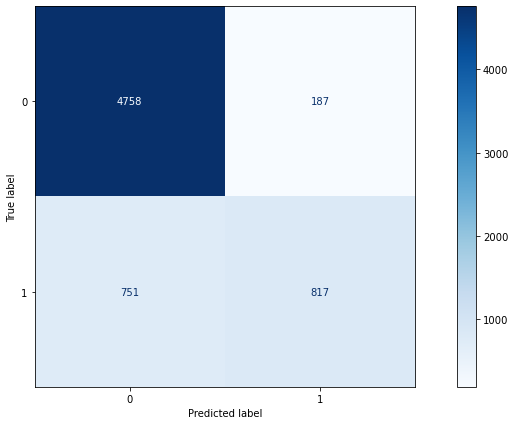

In [17]:
plot_cm(model_tree, X_validation, y_validation)

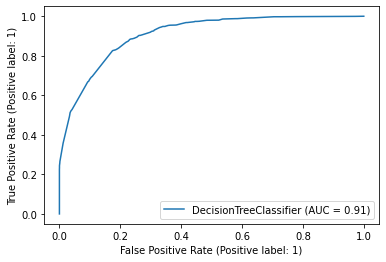

In [18]:
plot_roc_curve(model_tree, X_validation, y_validation, response_method="predict_proba")
plt.show()

## Preprocesamiento 2: Reducción de columnas + OHE 

A diferencia del preprocesado anterior, ahora reduciremos algunas columnas y luego aplicaremos OHE a las columnas categoricas. Al realizar esta primera reduccion de columnas obtendremos asi una reduccion dimensional cuando aplicaremos OHE. Reduciremos mediante la funcion **reduce_by_frequency_occurrence** que por predeterminado tiene las columnas *Barrio, Religion, Categoria de Trabajo, Estado Marital*:

In [19]:
X_p2 = pr.reduce_by_frequency_occurrence(X)

In [21]:
pr.init_OHE(X_p2)

In [22]:
X_p2 = pr.apply_OHE(X_p2)

Realizamos la particion de nuestros datos en *train* y *validation*:

In [23]:
X_train_p2, X_validation_p2, y_train_p2, y_validation_p2 = train_test_split(X_p2,y, test_size=0.2, stratify=y)

Busco los mejores hiperparametros para el arbol de decision con randomsearch. La metrica que se utiliza para comparar los modelos en cada iteracion es *roc_auc_score*:

In [24]:
parameters = {
    'criterion': ["gini","entropy"],
    'max_depth': np.arange(1, 10),
    'min_samples_leaf': np.arange(1, 300,10),
}

clf = DecisionTreeClassifier()

gscv = GridSearchCV(
    clf, parameters, scoring='roc_auc',n_jobs=-1, cv=5, return_train_score=True
).fit(X_train_p2, y_train_p2)

print(f"Best score: {gscv.best_score_}")
print(f"Best params {gscv.best_params_}")
print("------------------")
print(f"Score in Validation: {gscv.score(X_validation_p2, y_validation_p2)}")

Best score: 0.9044635578105277
Best params {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 51}
------------------
Score in Validation: 0.9004507490559418


Armo el modelo de arbol de decision con los hiperparametros calculados:

In [26]:
model_tree_p2 = gscv.best_estimator_
model_tree_p2

DecisionTreeClassifier(max_depth=9, min_samples_leaf=51)

Predigo con el validation set:

In [27]:
tree_predict = model_tree_p2.predict(X_validation_p2)

**Metricas**

In [28]:
print(classification_report(y_validation_p2, tree_predict))

              precision    recall  f1-score   support

           0       0.86      0.95      0.91      4945
           1       0.78      0.53      0.63      1568

    accuracy                           0.85      6513
   macro avg       0.82      0.74      0.77      6513
weighted avg       0.84      0.85      0.84      6513



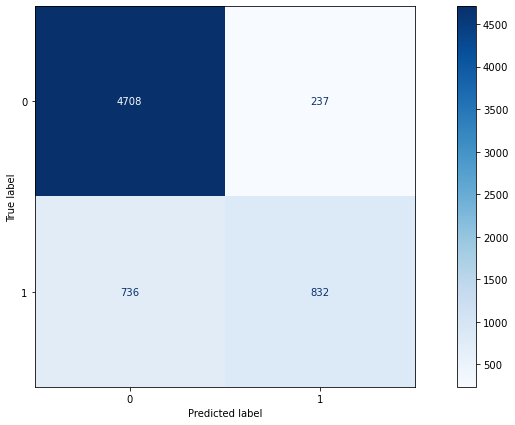

In [29]:
plot_cm(model_tree_p2, X_validation_p2, y_validation_p2)

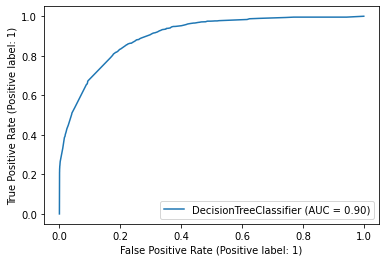

In [30]:
plot_roc_curve(model_tree_p2, X_validation_p2, y_validation_p2, response_method="predict_proba")
plt.show()

# Conclusión

Vimos que no hay mucha diferencia entre el preprocesamiento 1 y el preprocesamiento 2. A su vez, vimos que entrenando el arbol con los datos aplicandole unicamente OHE obtenemos un mejor resultado de la metrica AUC_ROC. Entonces nos quedaremos con el primer modelo. Una de las ventajas del arbol de deicision es que tiene facil interpretabilidad por lo que podemos mostrar como se visualiza este arbol obtenido:

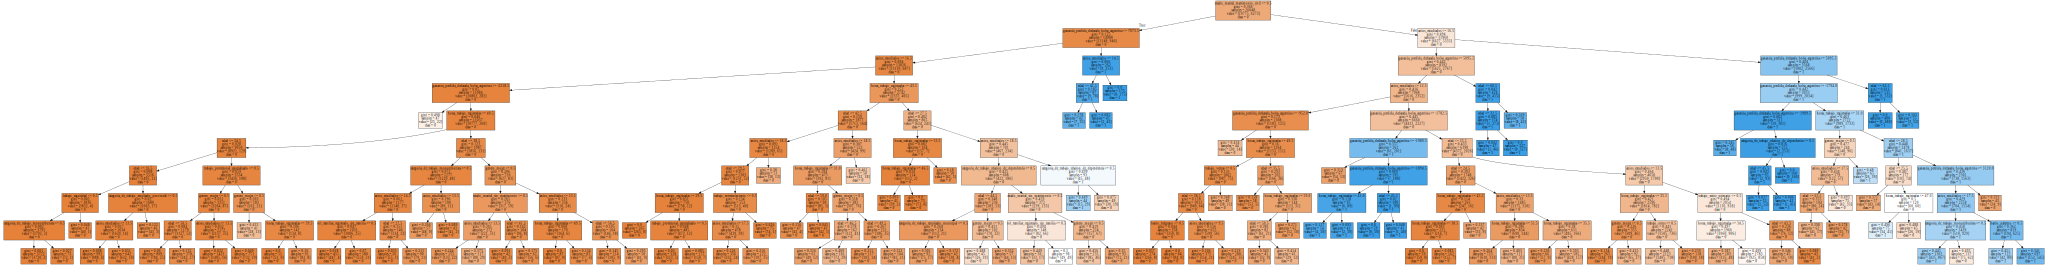

In [38]:
plot_tree(model_tree,X_train.columns)

# Predicción

In [39]:
ids, X_holdout = get_holdout_set()

In [40]:
X_holdout = pr.feature_engineering(X_holdout)

In [42]:
pr.init_OHE(X)

In [43]:
X_holdout_ohe = pr.apply_OHE(X_holdout)

In [44]:
tree_predict = model_tree.predict(X_holdout_ohe)

In [45]:
create_prediction(ids,tree_predict,file_name='arbol_desicion_prediction')